# Fire Boundary and OpenEO

This notebook demonstrates how to detect wildfire boundaries using Sentinel-2 imagery. Identifying fire-affected areas is essential for understanding event impact, helping firefighters manage fire spread, and measuring recovery efforts.

The script uses Sentinel-2's Band 11 and Band 12 to highlight affected areas with enhanced contrast and detail. Burned areas show high and positive coefficient number (bright in visualization), while unburned shows lower or negative values (dark in visualization).

$$\text{Fire Boundary Coefficient} = \frac{8.5 * (B_{12} - B_{11})}{(B_{12} + B_{11} + 0.25)}$$

In [4]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import if_, and_

## Connect to OpenEO Backend

Connect to the OpenEO backend and authenticate using OpenID Connect.

In [2]:
connection = openeo.connect(
    url="https://openeo.dataspace.copernicus.eu/"
).authenticate_oidc()

Authenticated using refresh token.


## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates for Melbourne, Australia. You can modify these coordinates to analyze any terrestrial land prone to fire.

In [3]:
# AOI for Melbourne, Australia
spatial_extent = {"west" : 146.55, "south" : -37.79, "east" : 146.90, "north" : -37.55}

## Load Sentinel-2 Data

Load Sentinel-2 L2A (bottom-of-atmosphere reflectance) data. We need multiple bands for Fire Boundary Coefficient calculation:

- **B11** (SWIR, 1613.7 nm)
- **B12** (SWIR, 2202.4 nm)

In [4]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=["2019-03-04", "2019-03-07"], # 
    bands=[
        "B11", 
        "B12"
    ],
)

# Filter for a specific date
s2cube = s2cube.reduce_dimension(dimension="t", reducer="first")

## Calculate Fire Boundary Coefficient

$$\text{Fire Boundary Coefficient} = \frac{8.5 * (B_{12} - B_{11})}{(B_{12} + B_{11} + 0.25)}$$

Then applying [HighlightCompressVisualizer from Evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/Utilities.html#parameters-8):

- Two-step brightness enhancer
- Fast linear enhancer from minValue to maxValue
- Slow linear enhancer from maxValue to `2 * maxValue - minValue`

**Key insight**
If `minValue == -1.0` and `maxValue == 1.0`, then slow linear enhancer starts from 1.0 to `2 * 1.0 - (-1.0) = 3.0`
| Segment | Input Range | Color Coding / Output Range | Color | 
|------------|-----------------|-------------|-------------|
| Fast | -1.0 -> 1.0 | 0 -> 0.9259 | Black -> Light gray |
| Slow | 1.0 -> 3.0 | 0.9259 -> 1 | Light gray -> White |

In [12]:
def fire_boundary_visualization(data):
    # Extract bands
    B11, B12 = (
        data[0],
        data[1]
    )

    # Calculate Fire Boundary Coefficient
    coefficient = 8.5 * (B12 - B11) / (B12 + B11 + 0.25)

    minValue = -1.0
    maxValue = 1.0

    # breakpoint_input is mapped to breakpoint_output
    breakpoint_input = maxValue
    breakpoint_output = 0.9259
    max_input = 2 * maxValue - minValue

    # First segment maps [min_value, max_value] to [0, ~0.9259]
    # Case 1: Values below min_value -> 0
    # Case 2: Linear mapping from min_value to breakpoint_input

    # Second segment maps [max_value, 2*max_value - min_value] to [~0.9259, 1.0]
    # Case 3: Compressed (slower) linear mapping from breakpoint to max_input
    # Case 4: Values at or above max_input -> 1

    slope_linear = breakpoint_output / (breakpoint_input - minValue)
    slope_compressed = (1.0 - breakpoint_output) / (max_input - breakpoint_input)

    result = if_(
        coefficient <= minValue, 
        0.0,
        if_(
            and_(coefficient > minValue, coefficient <= breakpoint_input), 
            slope_linear * (coefficient - minValue),
            if_(
                and_(coefficient > breakpoint_input, coefficient <= max_input),
                breakpoint_output + slope_compressed * (coefficient - breakpoint_input),
                1.0
            )
        )
    )

    return result

In [13]:
fire_image = s2cube.apply_dimension(dimension="bands", process=fire_boundary_visualization)

fire_image = fire_image.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

fire_image = fire_image.save_result("PNG")

In [14]:
fire_image.download("fire_boundary.png")

## Visualize the Result

Display the generated fire boundary map with the color-coded legend.

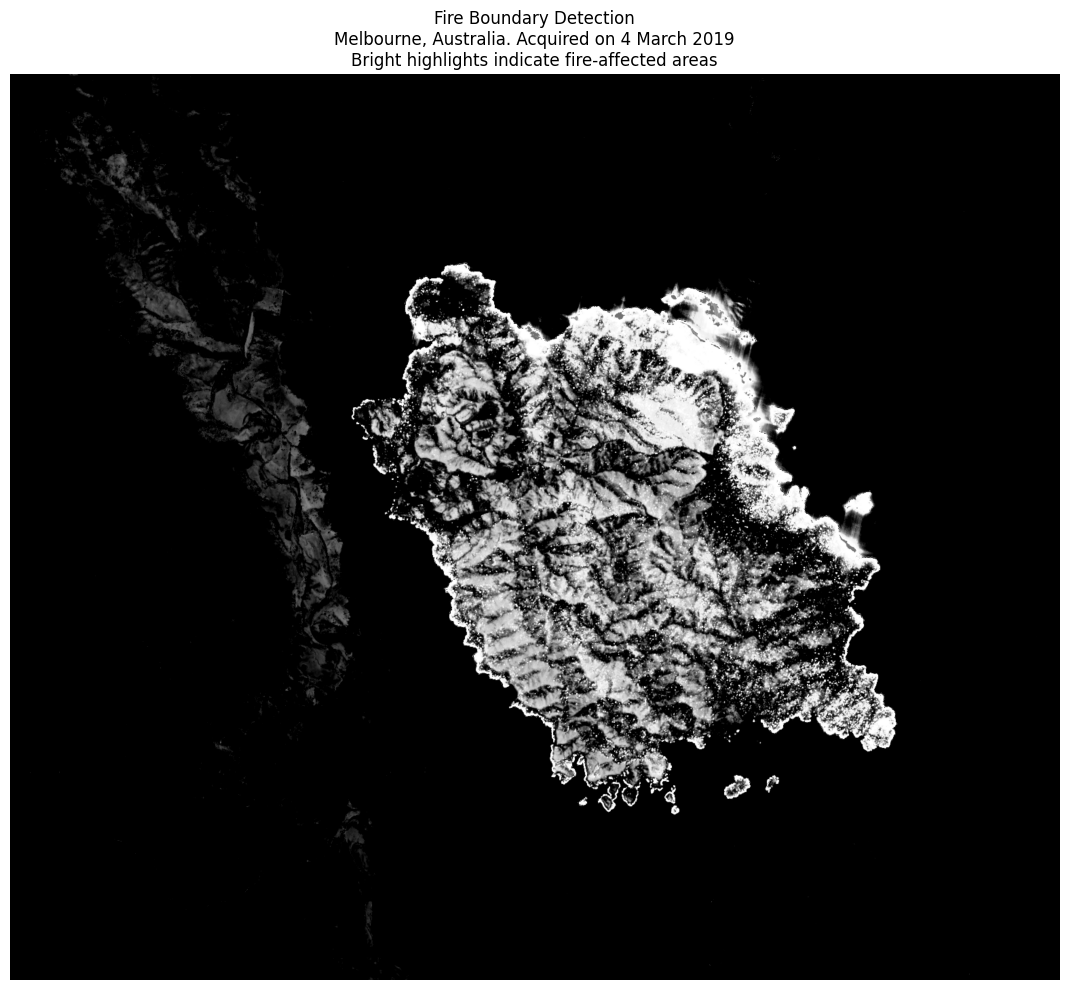

In [5]:
# Load and display the image
img = Image.open("fire_boundary.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img, cmap='gray')
ax.set_title(
    "Fire Boundary Detection\n"
    "Melbourne, Australia. Acquired on 4 March 2019\n"
    "Bright highlights indicate fire-affected areas",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()